In [1]:
from keras.models import Model
from keras.layers import Dense, Dropout
from keras.layers import GlobalAveragePooling2D
from keras.applications import VGG16

import os
import sys
import cv2
import numpy as np
import argparse
import tensorflow as tf
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
base_model = VGG16(include_top=False, weights='imagenet')
for layers in base_model.layers:
    layers.trainable = False
y = GlobalAveragePooling2D()(base_model.output)
y = Dropout(0.25)(y)
y = Dense(1, activation='sigmoid')(y)
model = Model(inputs=base_model.input, outputs=y)
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [3]:
checkpoint_path = "./output_model/checkpoint.ckpt"
model.load_weights(checkpoint_path)
dense_layer_weights = model.layers[-1].get_weights()[0]
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [4]:
def predict_on_weights(out_base, weights):
    gap = np.average(out_base, axis=(0, 1))
    logit = np.dot(gap, np.squeeze(weights))
    return 1 / (1 + np.e ** (-logit))


def getCAM(image, feature_maps, weights, display=False):
    
    predict = predict_on_weights(feature_maps, weights)
    
    # Weighted Feature Map
    cam = (predict - 0.5) * np.matmul(feature_maps, weights)
    # Normalize
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    # Resize as image size
    cam_resize = cv2.resize(cam, (224, 224))
    # Format as CV_8UC1 (as applyColorMap required)
    cam_resize = 255 * cam_resize
    cam_resize = cam_resize.astype(np.uint8)
    # Get Heatmap
    heatmap = cv2.applyColorMap(cam_resize, cv2.COLORMAP_JET)
    # Zero out
    heatmap[np.where(cam_resize <= 130)] = 0
    
    out = cv2.addWeighted(src1=image, alpha=0.8, src2=heatmap, beta=0.4, gamma=0)
    out = cv2.resize(out, dsize=(500, 500))
    
    if predict > 0.5:
        text = 'liver %.2f%%' % (predict * 100)
    else:
        text = 'non_liver %.2f%%' % (1 - predict * 100)
        
    cv2.putText(out, text, (210, 40), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.9, 
                  color=(123,222,238), thickness=2, lineType=cv2.LINE_AA)
    if display:
        plt.figure(figsize=(7, 7))
        plt.imshow(out[:, :, ::-1])
        plt.show()

# Segmentation result visualization

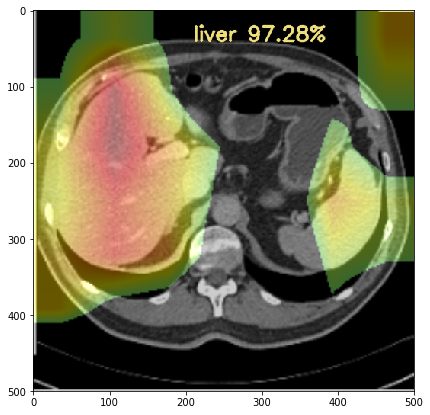

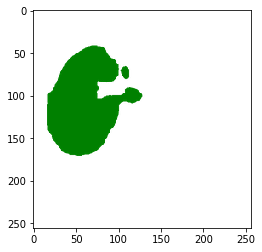

In [5]:
test_img = cv2.imread('./test_samples/input/012_368_5.png')
test_img = cv2.resize(test_img, (224, 224))

out_base = base_model.predict(np.expand_dims(test_img, axis=0))
out_base = out_base[0]

getCAM(image=test_img, feature_maps=out_base, weights=dense_layer_weights, display=True)

correct_seg = cv2.imread('./test_samples/output/012_368_5.png')
plt.imshow(correct_seg)

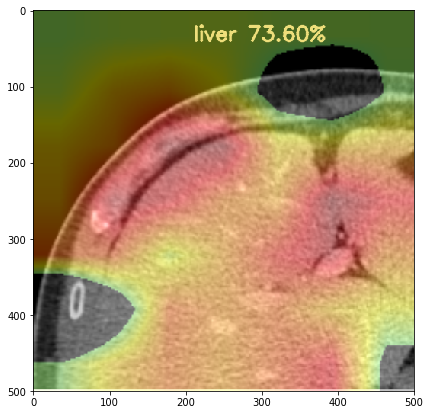

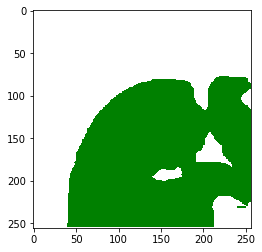

In [6]:
test_img = cv2.imread('./test_samples/input/012_380_0.png')
test_img = cv2.resize(test_img, (224, 224))

out_base = base_model.predict(np.expand_dims(test_img, axis=0))
out_base = out_base[0]

getCAM(image=test_img, feature_maps=out_base, weights=dense_layer_weights, display=True)

correct_seg = cv2.imread('./test_samples/output/012_380_0.png')
plt.imshow(correct_seg)

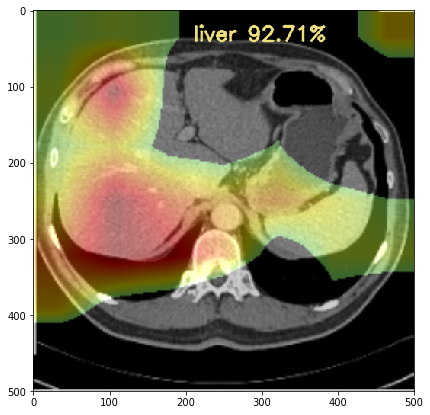

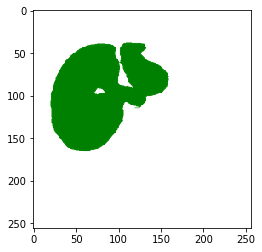

In [7]:
test_img = cv2.imread('./test_samples/input/012_383_5.png')
test_img = cv2.resize(test_img, (224, 224))

out_base = base_model.predict(np.expand_dims(test_img, axis=0))
out_base = out_base[0]

getCAM(image=test_img, feature_maps=out_base, weights=dense_layer_weights, display=True)

correct_seg = cv2.imread('./test_samples/output/012_383_5.png')
plt.imshow(correct_seg)